In [1]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation
from landlab.components.conduit_networks.calcite import calcite_diss_palmer_transfer

from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, vmin=0., vmax=0., cmap_name='viridis', magnitude= False, lw=5, pixels_per_node=15, x_name='X', y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixel_xscaling_factor)), int(round(grid.number_of_cell_rows*pixel_yscaling_factor)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


Populating the interactive namespace from numpy and matplotlib


In [2]:
mg = RasterModelGrid((25,25),500)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')

#set heads at edges
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'][mg.active_links]= 0.1*np.random.rand(mg.number_of_active_links)+0.1

rates = mg.add_zeros('link','diss__rates')

#code added for fsolve algorithm
#dhdx = mg.add_zeros('link', 'hydraulic_head_gradient')
#net_node_flux = mg.add_ones('node', 'net_node_flux')


pfn = PresFlowNetwork(mg, solutes=['Ca', 'PCO2'], 
                      transfer_func=calcite_diss_palmer_transfer,
                     transfer_func_link_variables = ['hydraulic__diameter','conduit__discharge'],
                     transfer_kwd_args = {'T_C':10.})
#Here need to set boundary conditions for transport calculation
#add input to node 310
Ca = mg.at_node['concentration__Ca']
PCO2 = mg.at_node['concentration__PCO2']

input_Q=.005
input_C = 0.0001
input_idx = 30#11
mg.at_node['input__discharge'][input_idx] = input_Q
mg.at_node['Ca__inflow_conc'][input_idx] = input_C 
mg.at_node['PCO2__inflow_conc'][input_idx] = 0.05

Ca[mg.nodes_at_left_edge] = 0.
Ca[mg.nodes_at_right_edge] = 0.
Ca[mg.nodes_at_top_edge] = 0.
Ca[mg.nodes_at_bottom_edge] = 0.

PCO2[mg.nodes_at_left_edge] = 0.1
PCO2[mg.nodes_at_right_edge] = 0.
PCO2[mg.nodes_at_top_edge] = 0.
PCO2[mg.nodes_at_bottom_edge] = 0.





pfn.run_one_step(transport=True)


#mg.at_link['Ca__conc_in']

Number of links =  1200
Number of nodes =  625
Number of active links =  1058
Number of core nodes =  529
Number of iterations = 1 tolerance = 0.138436878296  iteration time= 0.17184209823608398


/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:179: RuntimeWarning: divide by zero encountered in true_divide
  self.r = 8*f*L/(g*r_s**2.*d_h**5.)


Number of iterations = 2 tolerance = 0.0563911546984  iteration time= 0.16480016708374023
Number of iterations = 3 tolerance = 0.0468532749544  iteration time= 0.1570429801940918
Number of iterations = 4 tolerance = 0.0230613692064  iteration time= 0.16058969497680664
Number of iterations = 5 tolerance = 0.01249052884  iteration time= 0.1613173484802246
Number of iterations = 6 tolerance = 0.0113014488157  iteration time= 0.16609907150268555
Number of iterations = 7 tolerance = 0.00976586350753  iteration time= 0.1488966941833496
Number of iterations = 8 tolerance = 0.00452421239203  iteration time= 0.15784525871276855
Number of iterations = 9 tolerance = 0.00168034015344  iteration time= 0.17454743385314941
Number of iterations = 10 tolerance = 0.000489468112951  iteration time= 0.1795976161956787
Number of iterations = 11 tolerance = 0.000110293367985  iteration time= 0.15873122215270996
Number of iterations = 12 tolerance = 6.23256993634e-06  iteration time= 0.15500473976135254


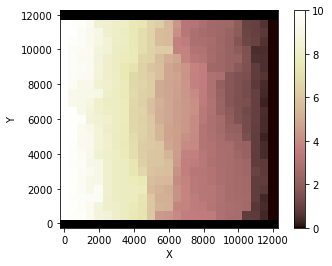

In [3]:
figure()
imshow_grid_at_node(mg, h)


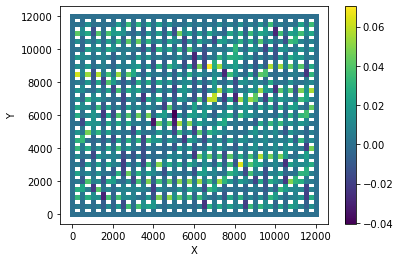

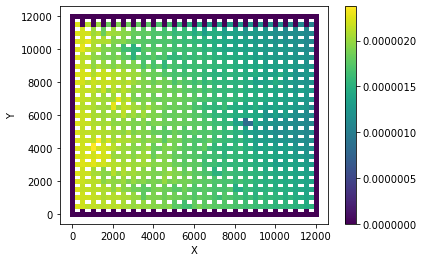

In [3]:
figure()
plot_links(mg, 'conduit__discharge', use_PIL=False)

figure()
plot_links(mg, 'diss__rates', use_PIL=False)

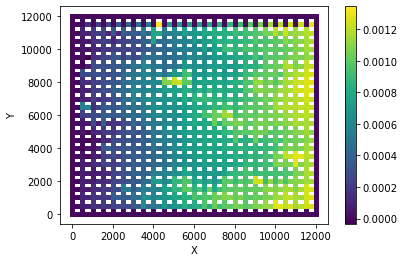

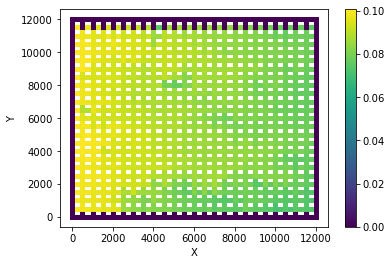

In [13]:
plot_links(mg, 'Ca__conc_in', use_PIL=False)
figure()
plot_links(mg, 'PCO2__conc_in', use_PIL=False)


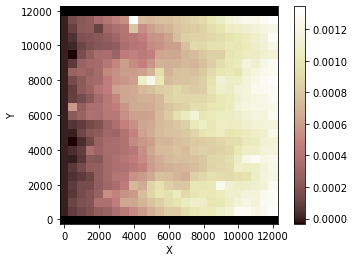

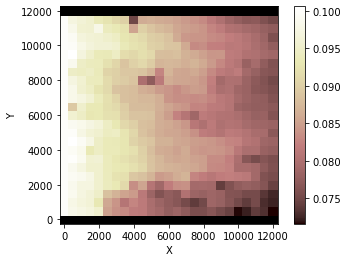

In [14]:
imshow_grid_at_node(mg, Ca)
figure()
imshow_grid_at_node(mg, PCO2)


In [5]:
#mg.at_node['concentration__Ca']
mg.at_link['diss__rates']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

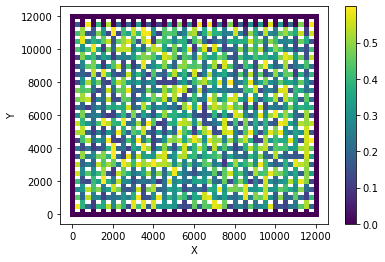

In [16]:
plot_links(mg, 'hydraulic__diameter', use_PIL=False)

In [7]:
this_node_links = mg.links_at_node[575]
this_node_dirs = mg.active_link_dirs_at_node[575]
print (this_node_dirs)
print(this_node_links)
node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
node_inflow_links = this_node_links[node_Qs>0]
node_outflow_links = this_node_links[node_Qs<0]
print(len(node_inflow_links))
print(node_outflow_links)

total_inflow = np.abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                            mg.at_node['input__discharge'][575]
print(total_inflow)


sum(np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['Ca__conc_out'][node_inflow_links])

[-1  0  0  0]
[1127 1151   -1 1102]
0
[1127]
0.0


0.0

In [6]:
mg.length_of_link

array([ 500.,  500.,  500., ...,  500.,  500.,  500.])

In [15]:
def test(a=1,b=2,c=3, d=None, e=0):
    return a*b*c*d*e

t1={'a':5,'b':42,'c':3}
t2 = {'d':4,'e':5}
test(**t2, **t1)

#test != None

12600

In [7]:
from olm.calcite import palmerRate, concCaEqFromPCO2

In [10]:
palmerRate(25., [0.005,0.01], [0.5,0.75])
concCaEqFromPCO2(array([0.01,0.02]), T_C=array([15.,25.]))

array([ 0.00190117,  0.00205579])

In [11]:
#Get index of nodes sorted by descending head
idx = np.argsort(-h)#Sort on negative to get descending order sort
#Loop through nodes from highest to lowest hydraulic head
for node_idx in idx:
    #Determine link indicies and directions for this node
    this_node_links = mg.links_at_node[node_idx]
    this_node_dirs = mg.active_link_dirs_at_node[node_idx]

    #Determine which links have inflow and outflow to/from node
    node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
    node_inflow_links = this_node_links[node_Qs>0]
    node_outflow_links = this_node_links[node_Qs<0]

    #Calculate node concentration from inflows (including boundary inflows)
    total_inflow = abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                    mg.at_node['input__discharge'][node_idx]

    #avoid cases with no inflow (e.g. closed boundaries)
    if total_inflow !=0:
        #Will need a loop here to loop through solutes
        conc_mult = np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['conduit__conc_out'][node_inflow_links]
        input_conc_mult = mg.at_node['input__discharge'][node_idx]*mg.at_node['input__concentration'][node_idx]
        conc_node = (conc_mult.sum() + input_conc_mult)/total_inflow
        C[node_idx] = conc_node
        
        #set outflow link concentrations
        mg.at_link['conduit__conc_in'][node_outflow_links] = conc_node
        
        #Calculate output link concentrations (for now conservative)
        mg.at_link['conduit__conc_out'][node_outflow_links] = mg.at_link['conduit__conc_in'][node_outflow_links]




FieldError: conduit__conc_out